# APA Laboratori 7  - SVMs 

In [1]:
# Uncomment to upgrade packages
# !pip3 install pandas --upgrade --user --quiet
# !pip3 install numpy --upgrade --user --quiet
# !pip3 install scipy --upgrade --user --quiet
# !pip3 install statsmodels --upgrade --user --quiet
# !pip3 install scikit-learn --upgrade --user --quiet
%load_ext autoreload

In [2]:
#%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.core.interactiveshell import InteractiveShell
pd.set_option('precision', 3)
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Exta imports
from numpy.random import uniform, normal
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVR

In [4]:
np.random.seed(7)

## Modelling artificial 2D sinusoidal data for two-class problems

First we create a simple two-class data set:

In [5]:
N = 200

def make_sinusoidals(m,noise=0.2):
  x1 = np.ones(2*m)
  x2 = np.ones(2*m)
  
  for i in range(m):
    x1[i] = (i/m) * np.pi
    x2[i] = np.sin(x1[i]) + normal(0,noise,1)
  
  
  for j in range(m): 
    x1[m+j] = (j/m + 1/2) * np.pi
    x2[m+j] = np.cos(x1[m+j]) + normal(0,noise,1)
  
  
  target = [1]*m+[-1]*m
  
  return pd.DataFrame({'x1':x1,'x2':x2,'t':target})


 let's generate the data

In [6]:
dataset = make_sinusoidals(N)

and have a look at it

In [7]:
dataset.describe()

,x1,x2,t
count,400.000,400.000,400.000
mean,2.348,-0.010,0.000
std,1.201,0.739,1.001
min,0.000,-1.402,-1.000
25%,1.567,-0.675,-1.000
50%,2.348,-0.040,0.000
75%,3.130,0.677,1.000
max,4.697,1.450,1.000


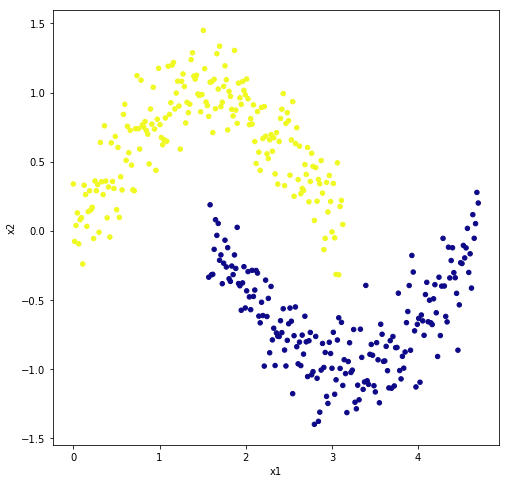

In [8]:
dataset.plot.scatter(x='x1', y='x2', c='t', 
                     colormap='plasma',
                     figsize=(8,8),
                     colorbar=False);

Now we wish to fit and visualize different SVM models

### model 1: LINEAR kernel, C=1 (cost parameter)

In [9]:
svc = SVC(C=1, kernel='linear')
svc.fit(dataset.loc[:,'x1':'x2'], dataset.t)

print('Suports=',svc.n_support_)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Suports= [26 25]


 Now we are going to visualize what we have done; since we have artificial data, instead of creating
 a random test set, we can create a grid of points as test

In [10]:
def plot_prediction(model, model_name, resol=200, ax=None):
    x_min, x_max = dataset.x1.min(), dataset.x1.max()
    y_min, y_max = dataset.x2.min(), dataset.x2.max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resol),
                         np.linspace(y_min, y_max, resol))
    
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(Z, interpolation='bilinear', 
              cmap=cm.RdYlGn, 
              extent=[x_min, x_max, y_min,y_max])
    dataset.plot.scatter(x='x1', y='x2', c='t', 
                         colormap='plasma',
                         colorbar=False,
                         ax=ax,
                         title=model_name+', supp=%d'%np.sum(model.n_support_))
    dataset.iloc[model.support_].plot.scatter(x='x1', y='x2', c='t', 
                                              colormap='bwr',
                                              colorbar=False,
                                              ax=ax,marker='x',
                                              s=40)
    CS=ax.contour(xx, yy, Z, levels=[-1,0,1],colors=['grey','black','grey'])
    plt.clabel(CS, inline=1, fontsize=10)


<div class="alert alert-block alert-info"> make sure you understand the following results (one by one and their differences)</div>

plot the data, the OSH with margins, the support vectors, ...

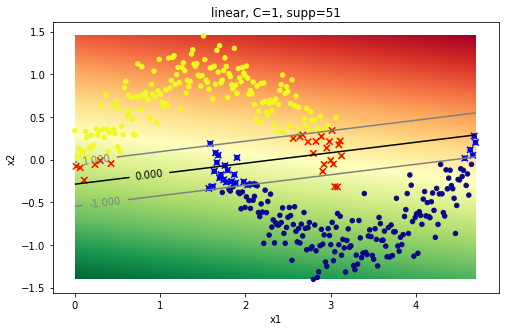

In [11]:
plot_prediction(svc, 'linear, C=1')

 ### model 2: linear kernel, C=0.1 (cost parameter)

In [12]:
svc = SVC(C=0.1, kernel='linear')
svc.fit(dataset.loc[:,'x1':'x2'], dataset.t)

print('Suports=',svc.n_support_)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Suports= [49 48]


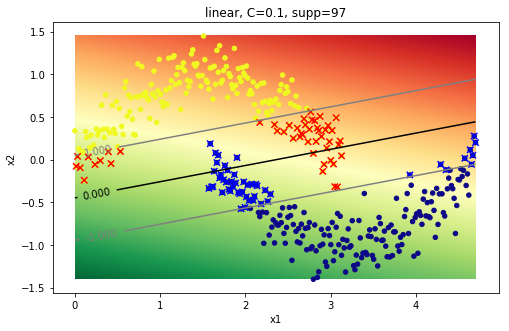

In [13]:
plot_prediction(svc, 'linear, C=0.1')

the margin is wider (lower VC dimension), number of support vectors is larger (more violations of the margin)

### model 3: linear kernel, C=25 (cost parameter)

In [14]:
svc = SVC(C=25, kernel='linear')
svc.fit(dataset.loc[:,'x1':'x2'], dataset.t)

print('Suports=',svc.n_support_)

SVC(C=25, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Suports= [18 18]


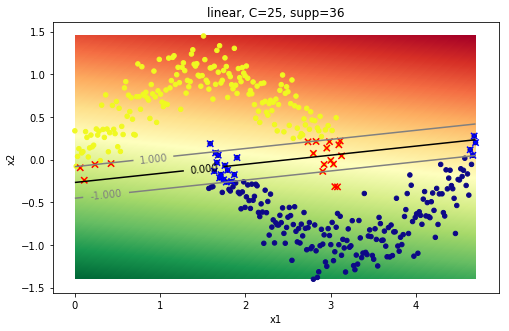

In [15]:
plot_prediction(svc, 'linear, C=25')

the margin is narrower (higher VC dimension), number of support vectors is smaller (less violations of the margin)

Let's put it together, for 6 values of C:

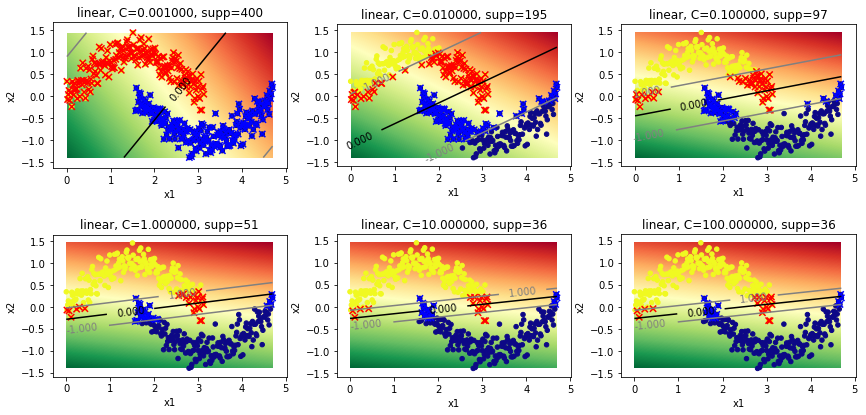

In [16]:
fig, ax = plt.subplots(2,3,figsize=(12,6))
for C, ax in zip(10**np.linspace(-3,2,6),ax.ravel()):
    svc = SVC(C=C, kernel='linear').fit(dataset.loc[:,'x1':'x2'], dataset.t)
    plot_prediction(svc, 'linear, C=%f'%C,ax=ax)
plt.tight_layout()

Now we move to a QUADRATIC kernel (polynomial of degree 2); the kernel has the form:

$k(x,y) = (\lt x,y\gt + coef0)^{degree}$

 quadratic kernel, C=1 (cost parameter)

In [17]:
svc = SVC(C=1, kernel='poly',degree=2,coef0=1)
svc.fit(dataset.loc[:,'x1':'x2'], dataset.t)

print('Suports=',svc.n_support_)

/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=2, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Suports= [21 22]


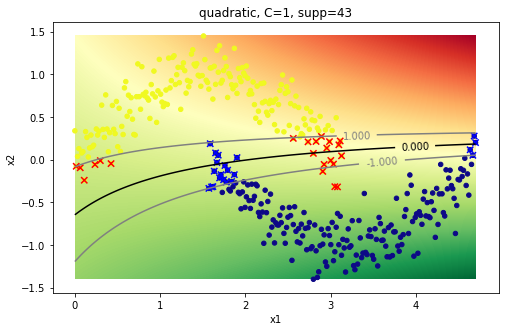

In [18]:
plot_prediction(svc, 'quadratic, C=1')

notice that neither the OSH or the margins are linear (they are quadratic); they are linear in the feature space
 in the previous linear kernel, both spaces coincide

Let's put it together directly, for 6 values of C:

/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:

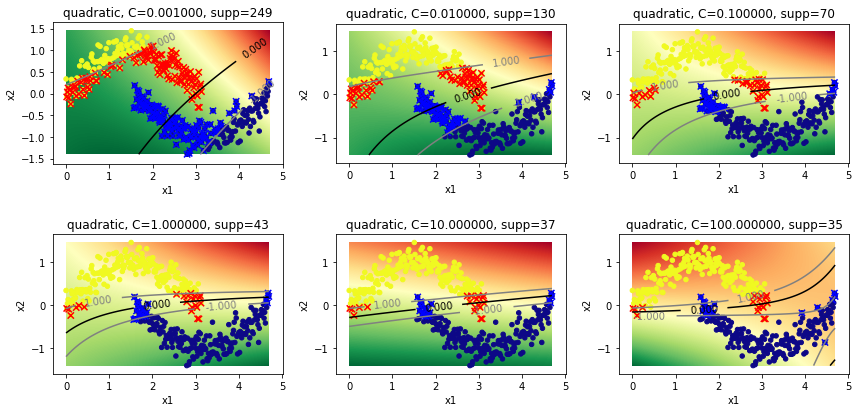

In [19]:
fig, ax = plt.subplots(2,3,figsize=(12,6))
for C, ax in zip(10**np.linspace(-3,2,6),ax.ravel()):
    svc = SVC(C=C, 
              kernel='poly',
              degree=2,
              coef0=1).fit(dataset.loc[:,'x1':'x2'], 
                           dataset.t)
    plot_prediction(svc, 'quadratic, C=%f'%C,ax=ax)
plt.tight_layout()

Now we move to a CUBIC kernel (polynomial of degree 3); the kernel has the form:

$k(x,y) = (\lt x,y \gt + coef0)^{degree}$

 cubic kernel, C=1 (cost parameter)

In [20]:
svc = SVC(C=1, kernel='poly',degree=3,coef0=1)
svc.fit(dataset.loc[:,'x1':'x2'], dataset.t)

print('Suports=',svc.n_support_)

/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Suports= [16 17]


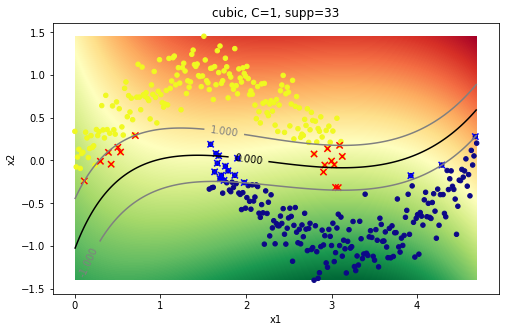

In [21]:
plot_prediction(svc, 'cubic, C=1')

 notice that neither the OSH or the margins are linear (they are now cubic); they are linear in the feature space
 this choice seems much better, given the structure of the classes

Let's put it together directly, for 6 values of C:

/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:

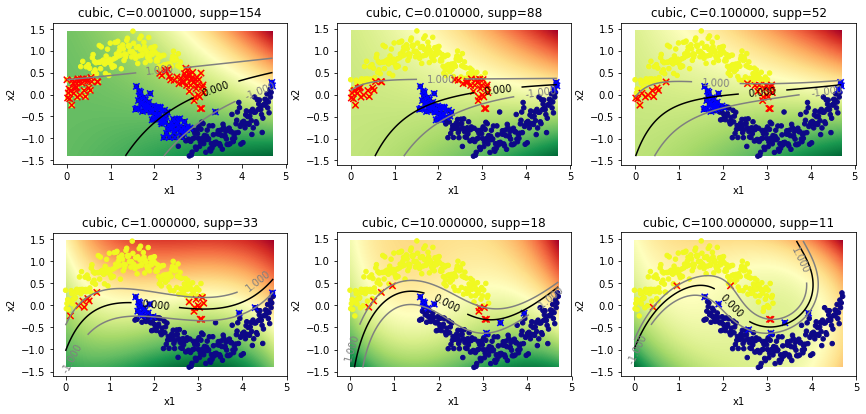

In [22]:
fig, ax = plt.subplots(2,3,figsize=(12,6))
for C, ax in zip(10**np.linspace(-3,2,6),ax.ravel()):
    svc = SVC(C=C, 
              kernel='poly',
              degree=3,
              coef0=1).fit(dataset.loc[:,'x1':'x2'], 
                           dataset.t)
    plot_prediction(svc, 'cubic, C=%f'%C,ax=ax)
plt.tight_layout()

Finally we use the Gaussian RBF kernel (polynomial of infinite degree; the kernel has the form:

$k(x,y) = exp(-gamma·||x - y||^2)$

RBF kernel, C=1 (cost parameter)

In [23]:
svc = SVC(C=1, kernel='rbf',gamma=0.5)
svc.fit(dataset.loc[:,'x1':'x2'], dataset.t)

print('Suports=',svc.n_support_)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Suports= [16 15]


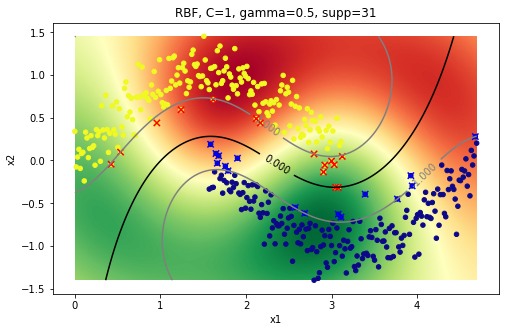

In [24]:
plot_prediction(svc, 'RBF, C=1, gamma=0.5')

 Let's put it together directly, for 6 values of C, holding gamma constant = 0.5:

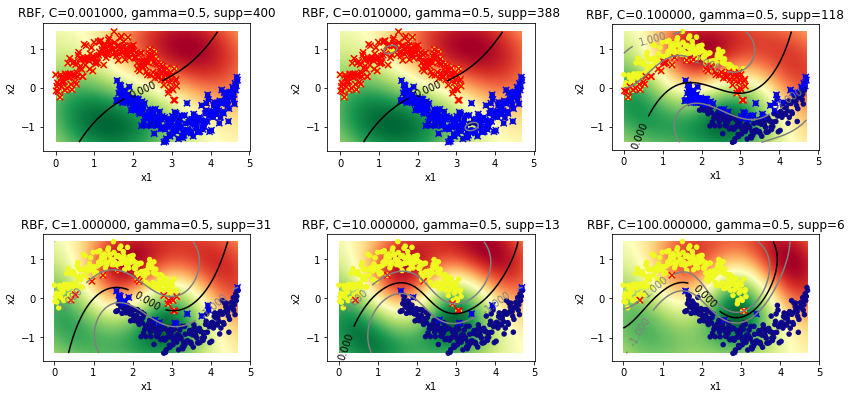

In [25]:
fig, ax = plt.subplots(2,3,figsize=(12,6))
for C, ax in zip(10**np.linspace(-3,2,6),ax.ravel()):
    svc = SVC(C=C,  
              kernel='rbf',
              gamma=0.5).fit(dataset.loc[:,'x1':'x2'], 
                             dataset.t)
    plot_prediction(svc, 'RBF, C=%f, gamma=0.5'%C,ax=ax)
plt.tight_layout()

 Now for 8 values of gamma, holding C constant = 1:

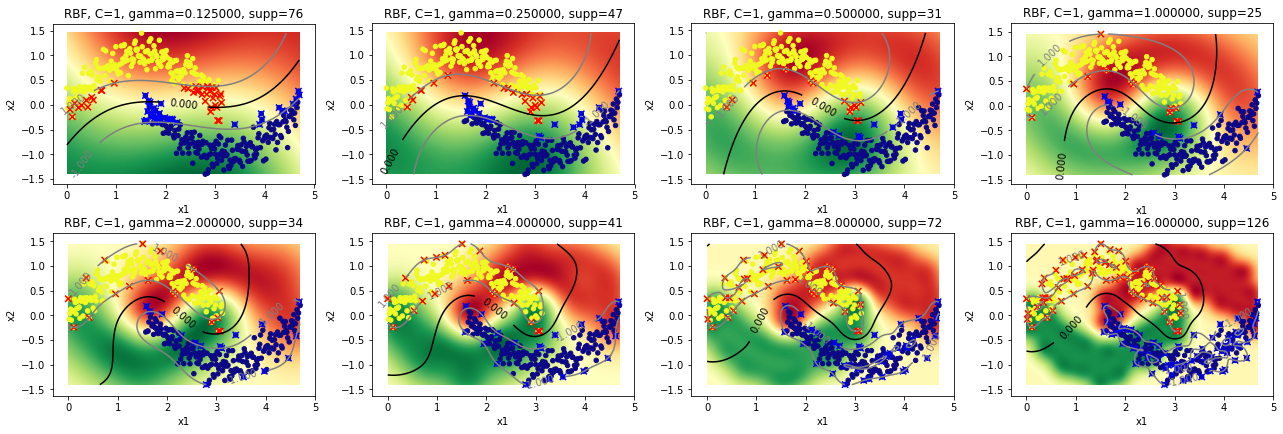

In [26]:
fig, ax = plt.subplots(2,4,figsize=(18,6))
for gamma, ax in zip(2**np.linspace(-3,4,8),ax.ravel()):
    svc = SVC(C=1,  
              kernel='rbf',
              gamma=gamma).fit(dataset.loc[:,'x1':'x2'], 
                               dataset.t)
    plot_prediction(svc, 'RBF, C=1, gamma=%f'%gamma,ax=ax)
plt.tight_layout()

 In practice we should optimize both (C,gamma) at the same time

 How? Using cross-validation or trying to get "good" estimates analyzing the data

 Now we define a utility function for performing k-fold CV: a typical choice is k=10

In [27]:
k = 10 

In [28]:
def train_svm_kCV(C,  k, kCV=10, params={'kernel':'linear'}):
    merr = 0.0
    for i in range(kCV):
        cv = KFold(n_splits=k)
        for tr_ind,ts_ind in cv.split(dataset):
            svc = SVC(C=C, 
                      **params).fit(dataset.iloc[tr_ind,[0,1]], 
                                    dataset.t.iloc[tr_ind])
            pred = svc.predict(dataset.iloc[ts_ind,[0,1]])
            merr += (1-accuracy_score(dataset.t.iloc[ts_ind],pred))
    return merr/(kCV*k)*100
            

In [29]:
C = 10

VA_error_linear = train_svm_kCV (C=C, k=10, params={'kernel':'linear'})
VA_error_linear

17.749999999999996

procedure is to choose the model with the lowest CV error and then refit it with the whole learning data,
 then use it to predict the test set; we will do this at the end

 Fit an SVM with quadratic kernel 

In [30]:
VA_error_poly_2 = train_svm_kCV (C=C, k=10, 
                                 params={'kernel':'poly', 'degree':2,'coef0':1})
VA_error_poly_2

/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:

/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:

/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:

25.250000000000007

 Fit an SVM with cubic kernel

In [31]:
VA_error_poly_3 = train_svm_kCV (C=C, k=10, 
                                 params={'kernel':'poly', 'degree':3,'coef0':1})
VA_error_poly_3

/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:

/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:

/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:

/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:

6.7500000000000036

In [32]:
VA_error_rbf = train_svm_kCV (C=C, k=10, params={'kernel':'rbf'})
VA_error_rbf

/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:

/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:

/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:

1.25

 Now in a real scenario we should choose the model with the lowest CV error
 which in this case is the RBF (we get a very low CV error because this problem is easy for a SVM)

 so we choose RBF and C=1 and refit the model in the whole training set (no CV)

In [33]:
svc = SVC(C=1,  kernel='rbf').fit(dataset.loc[:,'x1':'x2'], dataset.t)

/home/bejar/.local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 and make it predict a test set:

 let's generate the test data

In [34]:
dataset_test = make_sinusoidals (1000)

 and have a look at it

In [35]:
dataset_test.describe()

,x1,x2,t
count,2000.000,2000.000,2000.0
mean,2.355,0.005,0.0
std,1.200,0.730,1.0
min,0.000,-1.570,-1.0
25%,1.570,-0.653,-1.0
50%,2.355,0.003,0.0
75%,3.139,0.688,1.0
max,4.709,1.523,1.0


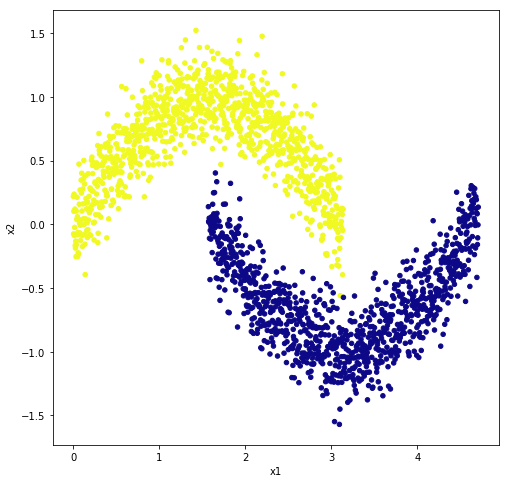

In [36]:
dataset_test.plot.scatter(x='x1', y='x2', c='t', 
                          colormap='plasma',
                          figsize=(8,8),
                          colorbar=False);

In [37]:
pred = svc.predict(dataset_test.loc[:,'x1':'x2']) 
df_tr=pd.DataFrame(confusion_matrix(dataset_test.t, pred), 
                   index=['-1','1'], columns=['-1','1'])
df_tr
(1-accuracy_score(dataset_test.t, pred))*100

,-1,1
-1,996,4
1,5,995


0.44999999999999485

 In a real setting we should also optimize the value of C, again with CV; all this can be done
 very conveniently using GridSearchCV to do automatic grid-search (very much as we did in the last
 laboratory for nnet)

 other packages provide with heuristic methods to estimate the gamma in the RBF kernel (see below)

[Here](https://dash-gallery.plotly.host/dash-svm) you can find  an interactive tool that allows to play with SVM

***

## Playing with the SVM for regression and 1D data

Now we do regression; we have an extra parameter: the 'epsilon', which controls the width of the 
epsilon-insensitive tube (in feature space)

In [38]:
A=20

 a really nice-looking function

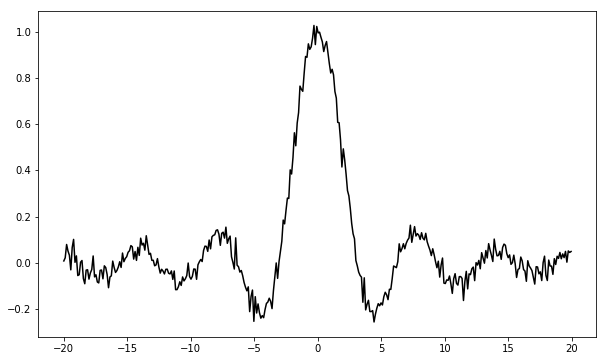

In [39]:
x = np.arange(-A,A,0.11)
y = (np.sin(x)/x) + normal(scale=0.03,size=len(x))
x = np.array(x).reshape(-1, 1)
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x,y,'k-');

With this choice of the 'epsilon', 'gamma' and C parameters, the SVM underfits the data (blue line) 

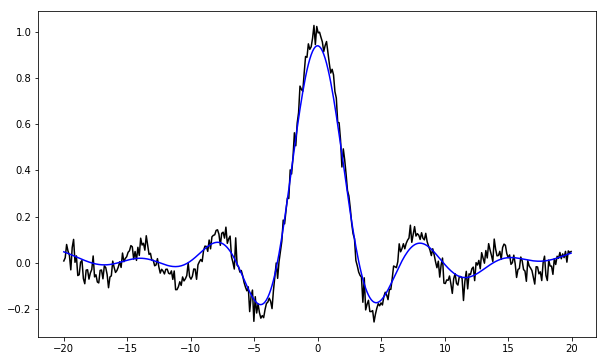

In [40]:
svr = SVR(epsilon=0.1,gamma=0.1).fit(x,y)
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x,y,'k-')
plt.plot(x,svr.predict(x),'b-');

With this choice of the 'epsilon', 'gamma' and C parameters, the SVM overfits the data (green line)

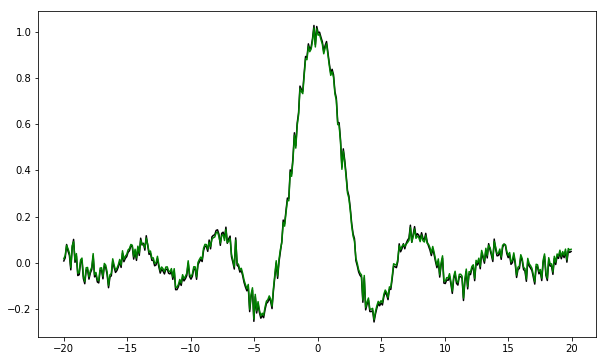

In [41]:
svr = SVR(epsilon=0.01,gamma=200, C=100).fit(x,y)
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x,y,'k-')
plt.plot(x,svr.predict(x),'g-');

With this choice of the 'epsilon', 'gamma' and C parameters, the SVM has a very decent fit (red line)

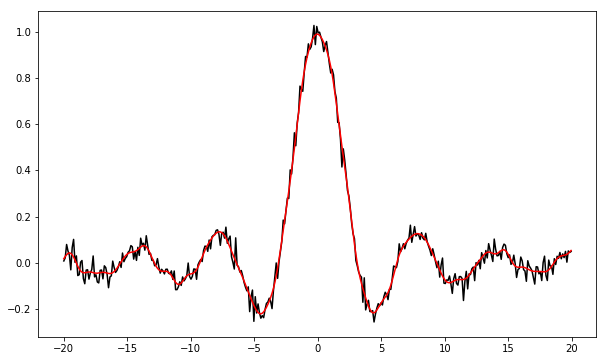

In [42]:
svr = SVR(epsilon=0.01,gamma=1).fit(x,y)
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x,y,'k-')
plt.plot(x,svr.predict(x),'r-');